## Arm Reaching (RM Session 1)

In [1]:
import os
import glob
import numpy as np
import mne
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from google.colab import drive
# drive.mount('/content/drive')
from scipy.io import loadmat
from scipy.signal import butter, lfilter

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne.decoding import CSP
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn import tree
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

### BrainVision (.vhdr, .vmrk, .eeg)

The BrainVision file format consists of three separate files:

1. A text header file (.vhdr) containing meta data.

2. A text marker file (.vmrk) containing information about events in the data.

3. A binary data file (.eeg) containing the voltage values of the EEG.

In [2]:
folder_path=r'D:\EEG_RawData\EEG_RawData\Arm-Reaching\RM'
folder_files=os.listdir(folder_path)
for i in folder_files:
    print(i)

session1_sub10_reaching_realMove.eeg
session1_sub10_reaching_realMove.vhdr
session1_sub10_reaching_realMove.vmrk
session1_sub11_reaching_realMove.eeg
session1_sub11_reaching_realMove.vhdr
session1_sub11_reaching_realMove.vmrk
session1_sub12_reaching_realMove.eeg
session1_sub12_reaching_realMove.vhdr
session1_sub12_reaching_realMove.vmrk
session1_sub13_reaching_realMove.eeg
session1_sub13_reaching_realMove.vhdr
session1_sub13_reaching_realMove.vmrk
session1_sub14_reaching_realMove.eeg
session1_sub14_reaching_realMove.vhdr
session1_sub14_reaching_realMove.vmrk
session1_sub15_reaching_realMove.eeg
session1_sub15_reaching_realMove.vhdr
session1_sub15_reaching_realMove.vmrk
session1_sub16_reaching_realMove.eeg
session1_sub16_reaching_realMove.vhdr
session1_sub16_reaching_realMove.vmrk
session1_sub17_reaching_realMove.eeg
session1_sub17_reaching_realMove.vhdr
session1_sub17_reaching_realMove.vmrk
session1_sub18_reaching_realMove.eeg
session1_sub18_reaching_realMove.vhdr
session1_sub18_reachi

In [3]:
eeg,vhdr,vmrk = [],[],[]

for i in folder_files:
    file=folder_path+'\\'+i
    if '.eeg' in file:
        eeg.append(file) 
    elif '.vhdr' in file:
        vhdr.append(file) 
    else:
        vmrk.append(file)
        
for i in range(0,len(eeg)):
    print(eeg[i]+'\n'+vhdr[i]+'\n'+vmrk[i]+'\n')

D:\EEG_RawData\EEG_RawData\Arm-Reaching\RM\session1_sub10_reaching_realMove.eeg
D:\EEG_RawData\EEG_RawData\Arm-Reaching\RM\session1_sub10_reaching_realMove.vhdr
D:\EEG_RawData\EEG_RawData\Arm-Reaching\RM\session1_sub10_reaching_realMove.vmrk

D:\EEG_RawData\EEG_RawData\Arm-Reaching\RM\session1_sub11_reaching_realMove.eeg
D:\EEG_RawData\EEG_RawData\Arm-Reaching\RM\session1_sub11_reaching_realMove.vhdr
D:\EEG_RawData\EEG_RawData\Arm-Reaching\RM\session1_sub11_reaching_realMove.vmrk

D:\EEG_RawData\EEG_RawData\Arm-Reaching\RM\session1_sub12_reaching_realMove.eeg
D:\EEG_RawData\EEG_RawData\Arm-Reaching\RM\session1_sub12_reaching_realMove.vhdr
D:\EEG_RawData\EEG_RawData\Arm-Reaching\RM\session1_sub12_reaching_realMove.vmrk

D:\EEG_RawData\EEG_RawData\Arm-Reaching\RM\session1_sub13_reaching_realMove.eeg
D:\EEG_RawData\EEG_RawData\Arm-Reaching\RM\session1_sub13_reaching_realMove.vhdr
D:\EEG_RawData\EEG_RawData\Arm-Reaching\RM\session1_sub13_reaching_realMove.vmrk

D:\EEG_RawData\EEG_RawData\A

### Read Raw Signals

In [4]:
raw = mne.io.read_raw_brainvision(vhdr[0], misc='auto', scale=1.0, preload=True, verbose=None)
raw # OR raw.info

Extracting parameters from D:\EEG_RawData\EEG_RawData\Arm-Reaching\RM\session1_sub10_reaching_realMove.vhdr...
Setting channel info structure...
Reading 0 ... 9804299  =      0.000 ...  3921.720 secs...


<RawBrainVision | session1_sub10_reaching_realMove.eeg, 71 x 9804300 (3921.7 s), ~5.19 GB, data loaded>

In [5]:
raw.set_channel_types(mapping={'hEOG_L': 'eog', 'hEOG_R': 'eog', 'vEOG_U': 'eog', 'vEOG_D': 'eog'})
raw.set_channel_types(mapping={'EMG_1': 'emg', 'EMG_2': 'emg', 'EMG_3': 'emg', 'EMG_4': 'emg', 'EMG_5': 'emg', 'EMG_6': 'emg', 'EMG_ref': 'emg'})
raw.info

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, AFz, F7, F5, F3, F1, Fz, FT7, FC5, FC3, FC1, T7, ...
 chs: 60 EEG, 4 EOG, 7 EMG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: 2019-07-08 10:49:32 UTC
 nchan: 71
 projs: []
 sfreq: 2500.0 Hz
>

In [114]:
print('bad channels:', raw.info['bads'])  # chs marked "bad" during acquisition
print(raw.info['sfreq'], 'Hz')            # sampling frequency
print(raw.info['description'], '\n')      # miscellaneous acquisition info

bad channels: []
2500.0 Hz
None 



Using matplotlib as 2D backend.


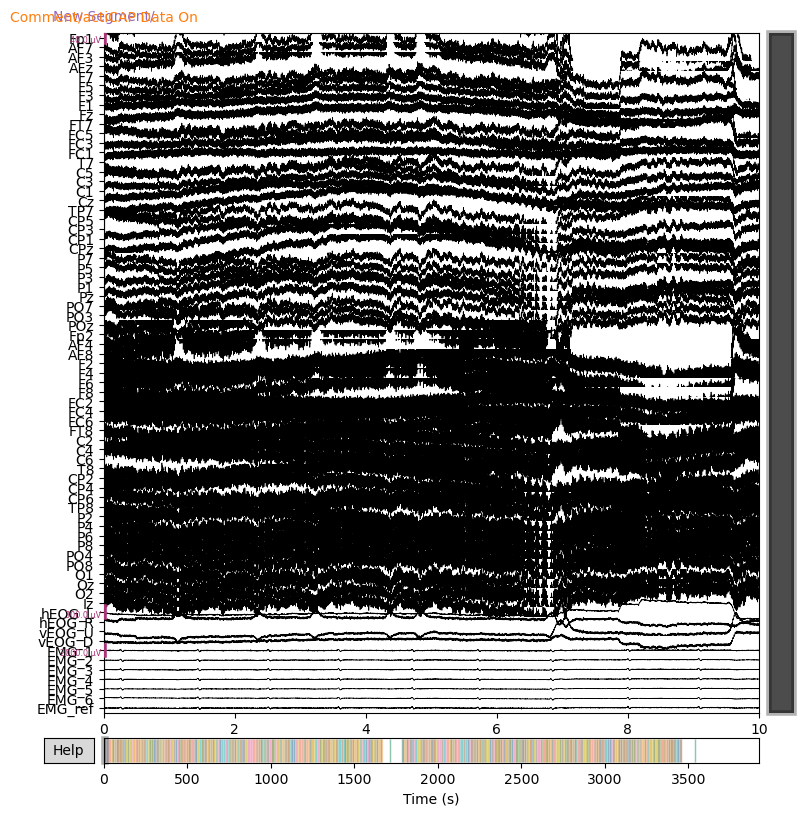

In [7]:
raw.plot(n_channels=71);

### For One Session, Each Subject Do :
 - 50 Trials For Each Class : 50 x 6 ( Classes ) = Total 300 Trials
 
 - Each Trial has Time Duration 7s ( 3s Visual Cue + 4s Movement Implementation )

 - and There Are 300 Rest Periods Between Those Trials ( Each Rest Period has Time Duration 4s )
 
 - Finally,
      Total Session Time = 50 x 6 x 7 + 300 x 4 = almost 3300 seconds 

In [8]:
print('First Time : ',raw.first_time)
print('Last Time  : ',raw._last_time)

First Time :  0.0
Last Time  :  3921.7196


- Therefore, The Total Count of Samples For All Trials : 300 ( Trials ) x 7s x 2500 (Fs) + 300 (Rests) x 4s x 2500 (Fs) is almost 8,250,000

In [9]:
print('Total Samples : ',len(raw))
print('Start : ',raw._first_samps) 
print('End : ',raw._last_samps)

Total Samples :  9804300
Start :  [0]
End :  [9804299]


### time_as_index()
- Convert time to indices ( time ( s ) : index ( 0-based ) )

- Input : List of numbers or a number representing points in time.

- Return : Indices relative to first_samp corresponding to the times supplied.

In [10]:
print(raw.time_as_index([1, 2, 3, 4, 5]), '\n')
print(np.diff(raw.time_as_index([1, 2, 3])))

[ 2500  5000  7500 10000 12500] 

[2500 2500]


### Electrodes Handling :
### pick_types() : Picking Some Type of Signals and Ignore Others.
### pick_channels() : pick channels by name.
### drop_channels() : method to remove channels by name.

In [11]:
# # this piece of code does not make changes in this case, only for learn

# eeg_and_eog = raw.copy().pick_types(emg=False, eeg=True, eog=True)
# print(len(raw.ch_names), '→', len(eeg_and_eog.ch_names))

### We Will Select Channels According to International Standard 10–20 system 

<img src="The-location-map-of-32-channels-cap-The-electrodes-can-be-divided-into-3-groups.png" style="width:400px;hight:400;"/>

In [37]:
print(raw.ch_names)

['Fp1', 'AF7', 'AF3', 'AFz', 'F7', 'F5', 'F3', 'F1', 'Fz', 'FT7', 'FC5', 'FC3', 'FC1', 'T7', 'C5', 'C3', 'C1', 'Cz', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'P7', 'P5', 'P3', 'P1', 'Pz', 'PO7', 'PO3', 'POz', 'hEOG_L', 'hEOG_R', 'vEOG_U', 'vEOG_D', 'Fp2', 'AF4', 'AF8', 'F2', 'F4', 'F6', 'F8', 'FC2', 'FC4', 'FC6', 'FT8', 'C2', 'C4', 'C6', 'T8', 'CP2', 'CP4', 'CP6', 'TP8', 'P2', 'P4', 'P6', 'P8', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Iz', 'EMG_1', 'EMG_2', 'EMG_3', 'EMG_4', 'EMG_5', 'EMG_6', 'EMG_ref']


In [38]:
selected_channels = ["Fp1", "AF3","F7","F3","FC1","FC5","T7","C3","CP1","CP5","P7","P3", "PO3", "O1",  # Brain Left Side
                     "Fz","Cz","Pz","Oz",                                                              # Brain Mid
                     "O2","FC2","F4","F8","AF4","Fp2","C4", "T8","FC6","CP2","PO4","P4","P8","CP6",    # Brain Right Side   
                     "hEOG_L", "hEOG_R", "vEOG_U", "vEOG_D"]                                           # EOG Channels                                

In [39]:
raw.pick_channels(ch_names=selected_channels)
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)
print(len(raw.ch_names))

36


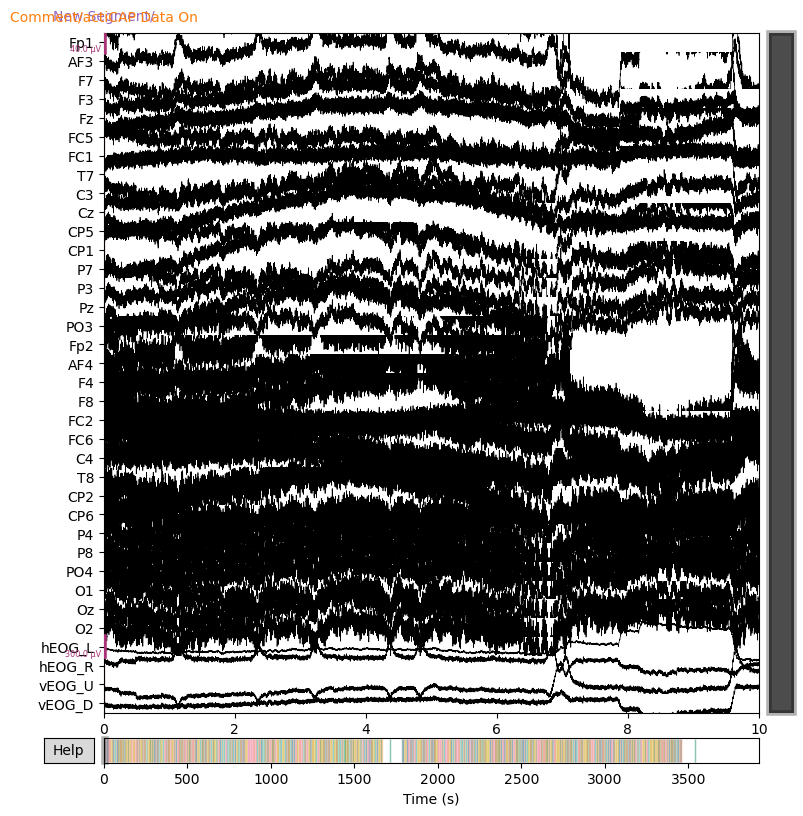

In [15]:
raw.plot(n_channels=36);

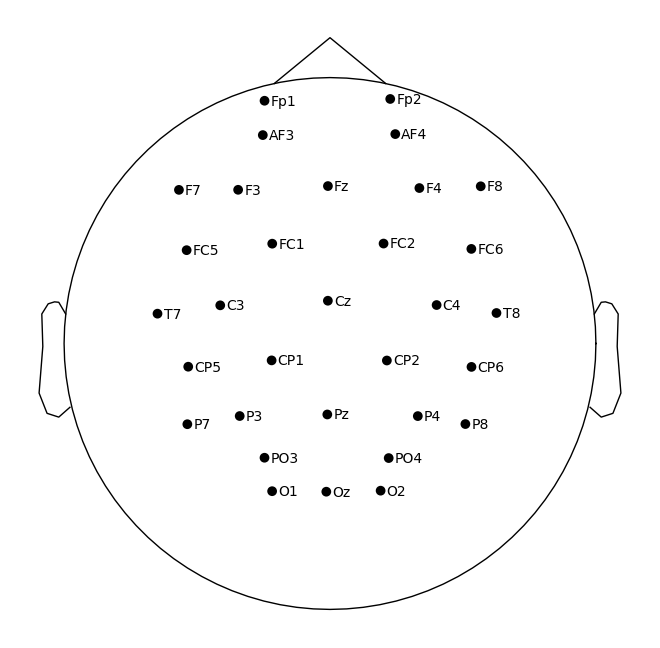

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.


In [16]:
raw.plot_sensors(show_names=True,sphere=0.11);
fig = montage.plot(kind='3d',show=False)
fig = fig.gca().view_init(azim=70, elev=15)  # set view angle for tutorial

### Plotting spectral density of continuous data

- To visualize the frequency content of continuous data

- the Raw object provides a compute_psd() method to compute spectral density and the resulting Spectrum object has a plot() method

Effective window size : 0.102 (s)


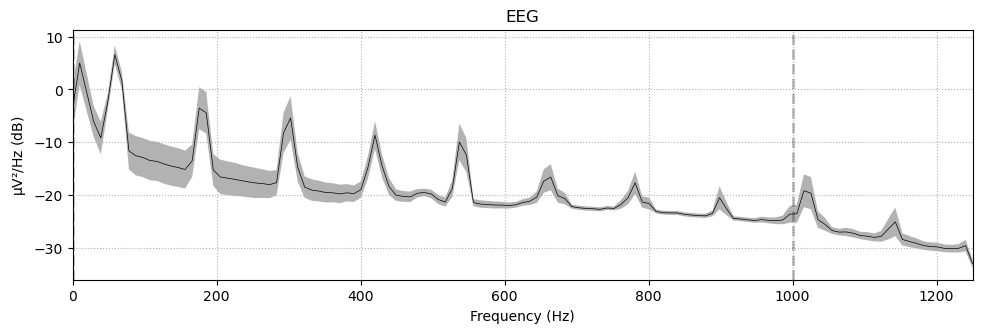

In [17]:
spectrum = raw.compute_psd()
spectrum.plot(average=True)

### plot spectral power estimates across sensors as a scalp topography
- will compute power based on magnetometer channels (if present), and will plot the power estimates on a dB-like log-scale.

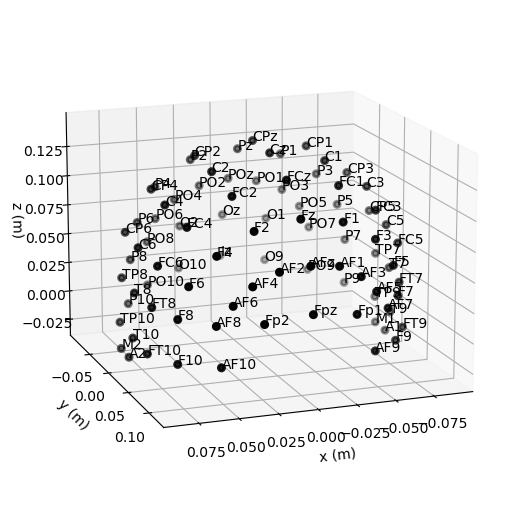

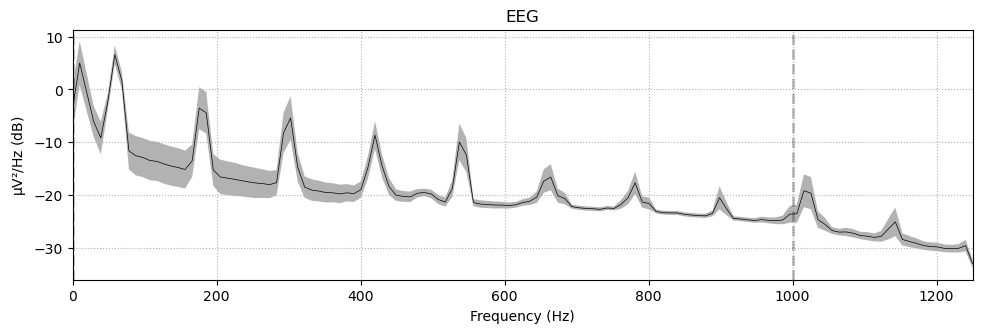

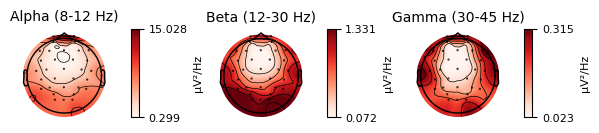

In [18]:
spectrum.plot_topomap(bands={'Alpha (8-12 Hz)': (8, 12), 'Beta (12-30 Hz)': (12, 30),'Gamma (30-45 Hz)': (30,45)});

### plot the PSD for every sensor on its own axes
- the axes arranged spatially to correspond to sensor locations in space.

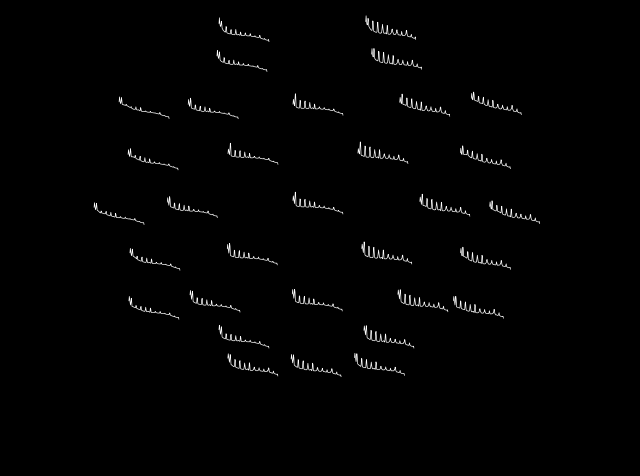

In [19]:
spectrum.plot_topo();

### Bandpass Filtering the Data
- Filtering to remove slow drift.
- Before we run the ICA, an important step is filtering the data to remove low-frequency drifts, which can negatively affect the quality of the ICA fit.

In [6]:
raw.filter(l_freq=8,h_freq=30)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 4125 samples (1.650 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   40.3s finished


<RawBrainVision | session1_sub10_reaching_realMove.eeg, 71 x 9804300 (3921.7 s), ~5.19 GB, data loaded>

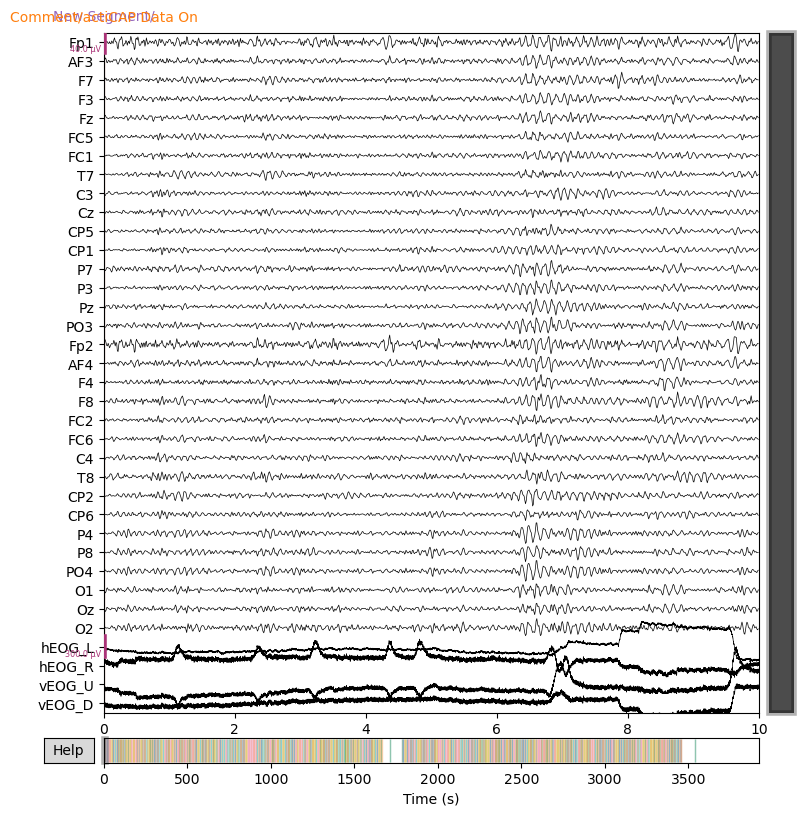

In [40]:
raw.plot(n_channels=36);

Effective window size : 0.102 (s)


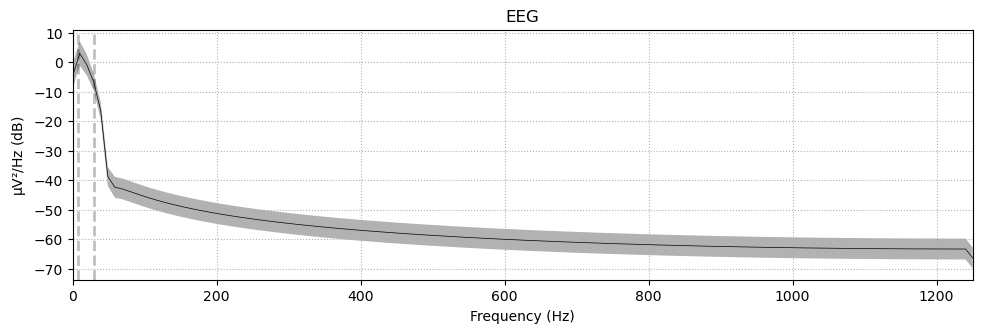

In [22]:
spectrum = raw.compute_psd()
spectrum.plot(average=True)

### Refrencing EEG

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


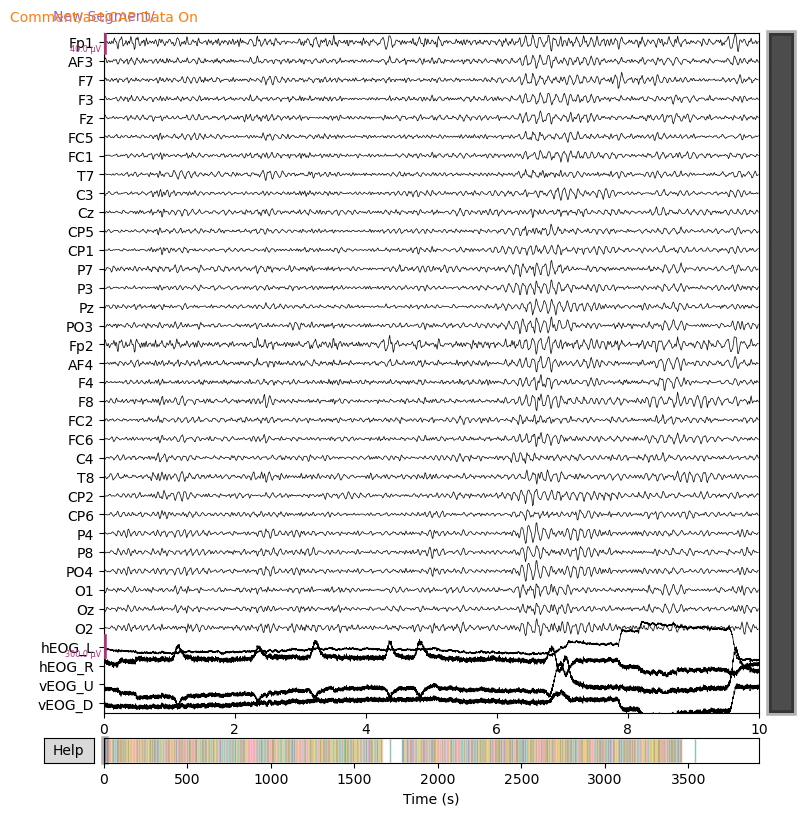

In [42]:
# Average reference. This is normally added by default, but can also be added
# explicitly.
raw.set_eeg_reference(ref_channels='average')
raw.plot(n_channels=36);

In [24]:
# ### Detect Ocular artifacts (EOG)

# - MNE-Python includes functions for detecting and extracting ocular artifacts: find_eog_events() and create_eog_epochs(). Once again we’ll use the higher-level convenience function that automatically finds the artifacts and extracts them in to an Epochs object in one step. 

# - ocular artifacts are usually most prominent in the EEG channels.

# - note that there are many fewer blinks than heartbeats, which makes the image plots appear somewhat blocky.

In [25]:
# # baseline : The electrical signal from a sensor when no measured variable is present. Often referred to the output at no-load condition
# eog_epochs = mne.preprocessing.create_eog_epochs(raw,ch_name=["hEOG_L", "hEOG_R", "vEOG_U", "vEOG_D"], baseline=(-0.5, -0.2))
# eog_epochs.plot_image(combine='mean');
# eog_epochs.average().plot_joint();

In [26]:
# eog_epochs

In [27]:
# ### Repairing artifacts with regression --Raw Data--
# Remove EOG artifact signals from other channels by regression.

In [28]:
# weights = mne.preprocessing.EOGRegression(picks='eeg', picks_artifact='eog').fit(raw)

In [29]:
# fig = weights.plot(vlim=(None, 0.4))  # regression coefficients / weights as topomap
# fig.set_size_inches(3, 2)

In [30]:
# # Fit the regression model
# raw_clean = weights.apply(raw, copy=False)

# # Show the filter weights in a topomap
# weights.plot();

In [31]:
# ### Repairing artifacts with ICA
# Note : ICA fitting is not deterministic (e.g., the components may get a sign flip on different runs, or may not always be returned in the same order), so we’ll also specify a random seed so that we get identical results each time this tutorial is built by our web servers

In [32]:
# ica = mne.preprocessing.ICA(n_components=32, max_iter='auto',random_state=0,method='infomax')
# ica.fit(raw.copy()) 

In [33]:
# ica.plot_components();

In [34]:
# # use automatic detection
# bad_indx,scores = ica.find_bads_eog(raw,ch_name=["hEOG_L","hEOG_R","vEOG_U","vEOG_D"],threshold=3,)
# print(bad_indx)

In [35]:
# raw.plot(n_channels=32);

In [36]:
# ica.exclude = bad_indx
# ica.apply(raw.copy(),exclude=ica.exclude).plot();

In [37]:
# ica.apply(raw,exclude=ica.exclude)

### Read Events & Epoching

In [43]:
events = mne.events_from_annotations(raw)

Used Annotations descriptions: ['Comment/ControlBox is not connected via USB', 'Comment/actiCAP Data On', 'Comment/actiCAP USB Power On', 'New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  8', 'Stimulus/S 11', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 21', 'Stimulus/S 31', 'Stimulus/S 41', 'Stimulus/S 51', 'Stimulus/S 61']


In [44]:
events

(array([[      0,       0,   99999],
        [      0,       0,   10002],
        [  41842,       0,      13],
        ...,
        [8641806,       0,      14],
        [8841700,       0,   10001],
        [8841800,       0,   10003]]),
 {'Comment/ControlBox is not connected via USB': 10001,
  'Comment/actiCAP Data On': 10002,
  'Comment/actiCAP USB Power On': 10003,
  'New Segment/': 99999,
  'Stimulus/S  1': 1,
  'Stimulus/S  2': 2,
  'Stimulus/S  3': 3,
  'Stimulus/S  4': 4,
  'Stimulus/S  5': 5,
  'Stimulus/S  6': 6,
  'Stimulus/S  8': 8,
  'Stimulus/S 11': 11,
  'Stimulus/S 13': 13,
  'Stimulus/S 14': 14,
  'Stimulus/S 21': 21,
  'Stimulus/S 31': 31,
  'Stimulus/S 41': 41,
  'Stimulus/S 51': 51,
  'Stimulus/S 61': 61})

In [45]:
selected_events = mne.pick_events(events[0], exclude=[99999,10001,10002,10003,1,2,3,4,5,6,13,14])
selected_events

array([[  59427,       0,      31],
       [  69470,       0,       8],
       [  87079,       0,      21],
       ...,
       [8609179,       0,       8],
       [8626757,       0,      31],
       [8636795,       0,       8]])

In [46]:
selected_events.shape

(600, 3)

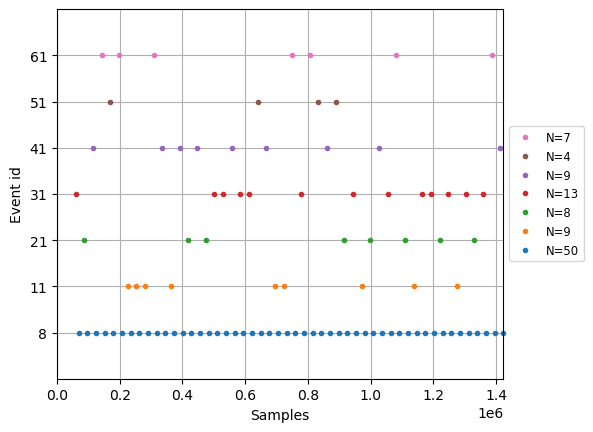

In [47]:
mne.viz.plot_events(selected_events[:100]);

In [70]:
event_ids = {'Stimulus/S 31': 31,'Stimulus/S 41': 41} # ,'Stimulus/S 31': 31,'Stimulus/S 41': 41,'Stimulus/S 51': 51,'Stimulus/S 61': 61}
epochs = mne.Epochs(raw, events=selected_events, event_id=event_ids, tmin=0, tmax=7, preload=True,baseline=(0, 0))

Not setting metadata
100 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 100 events and 17501 original time points ...
0 bad epochs dropped


In [71]:
epochs

Number of events,100
Events,Stimulus/S 31: 50Stimulus/S 41: 50
Time range,0.000 – 7.000 sec
Baseline,0.000 – 0.000 sec


In [72]:
epochs.get_data().shape

(100, 36, 17501)

In [73]:
epochs.crop(tmin=3,tmax=7,include_tmax=True)
epochs.get_data().shape

(100, 36, 10001)

In [74]:
# rest_epochs = mne.Epochs(raw, events=selected_events, event_id={'Stimulus/S 8': 8}, tmin=0, tmax=4, preload=True,baseline=(0, 0))
# print('=' * 40)
# rest_epochs.get_data().shape

### Epochs Downsampling

In [75]:
# epochs.resample(sfreq=625)
# epochs.get_data().shape

In [50]:
# rest_epochs.resample(sfreq=625)
# rest_epochs.get_data().shape

In [76]:
# epochs.plot(n_epochs=5);

In [ ]:
# rest_epochs.plot(n_epochs=5);

### Repairing artifacts with ICA 
Note : ICA fitting is not deterministic (e.g., the components may get a sign flip on different runs, or may not always be returned in the same order), so we’ll also specify a random seed so that we get identical results each time this tutorial is built by our web servers

### First ,  on main classes epochs

In [ ]:
# ica = mne.preprocessing.ICA(n_components=20, max_iter='auto',random_state=0,method='infomax')
# ica.fit(epochs.copy()) 

In [ ]:
# ica.plot_components();

In [ ]:
# # use automatic detection
# bad_indx,scores = ica.find_bads_eog(raw,ch_name=["hEOG_L","hEOG_R","vEOG_U","vEOG_D"],threshold=2)
# print(bad_indx)

In [ ]:
# epochs.plot(n_epochs=5);

In [ ]:
# ica.exclude = bad_indx
# ica.apply(epochs.copy(),exclude=ica.exclude).plot(n_epochs=5);

In [ ]:
# ica.apply(epochs,exclude=ica.exclude)

### Second ,  on rest_epochs

In [ ]:
# ica = mne.preprocessing.ICA(n_components=20, max_iter='auto',random_state=0,method='fastica')
# ica.fit(rest_epochs.copy()) 

In [ ]:
# ica.plot_components();

In [ ]:
# # use automatic detection
# bad_indx,scores = ica.find_bads_eog(raw,ch_name=["hEOG_L","hEOG_R","vEOG_U","vEOG_D"],threshold=2)
# print(bad_indx)

In [ ]:
# rest_epochs.plot(n_epochs=5);

In [ ]:
# ica.exclude = [2,3,6,13,0,19]
# ica.apply(epochs.copy(),exclude=ica.exclude).plot(n_epochs=5);

In [ ]:
# ica.apply(rest_epochs,exclude=ica.exclude)

In [ ]:
# ### Repairing artifacts with regression --Epochs--
# Remove EOG artifact signals from other channels by regression.

In [ ]:
# # plotting before
# # plot the evoked for the EEG and the EOG sensors
# fig = epochs.average('all').plot()
# fig.set_size_inches(6, 6)

In [ ]:
# # Perform regression using the EOG sensor as independent variable and the EEG
# # sensors as dependent variables.
# model_plain = mne.preprocessing.EOGRegression(picks='eeg', picks_artifact='eog').fit(epochs)
# fig = model_plain.plot(vlim=(None, 0.4))  # regression coefficients as topomap
# fig.set_size_inches(3, 2);

In [ ]:
# epochs_clean_plain = model_plain.apply(epochs)
# # After regression, we should redo the baseline correction
# epochs_clean_plain.apply_baseline(baseline=(3, 7))
# # Show the evoked potential computed on the corrected data
# fig = epochs_clean_plain.average('all').plot()
# fig.set_size_inches(6, 6)

In [ ]:
# # create epochs with the evoked subtracted out
# epochs_sub = epochs.copy().subtract_evoked()

# # perform regression
# model_sub = mne.preprocessing.EOGRegression(picks='eeg', picks_artifact='eog').fit(epochs_sub)
# fig = model_sub.plot(vlim=(None, 0.4))
# fig.set_size_inches(3, 2)

# # apply the regression coefficients to the original epochs
# epochs_clean_sub = model_plain.apply(epochs).apply_baseline(baseline=(3, 7))
# fig = epochs_clean_sub.average('all').plot()
# fig.set_size_inches(6, 6)

In [ ]:
# eog_epochs = mne.preprocessing.create_eog_epochs(raw)
# # We need to explicitly specify that we want to average the EOG channel too.
# eog_evoked = eog_epochs.average('all')
# eog_evoked.plot('all')
# fig.set_size_inches(6, 6)

# # perform regression on the evoked blink response
# model_evoked = mne.preprocessing.EOGRegression(picks='eeg', picks_artifact='eog').fit(eog_evoked)
# fig = model_evoked.plot(vlim=(None, 0.4))
# fig.set_size_inches(3, 2)

# # apply the regression coefficients to the original epochs
# epochs_clean_evoked = model_evoked.apply(epochs).apply_baseline(baseline=(3, 7))
# fig = epochs_clean_evoked.average('all').plot()
# fig.set_size_inches(6, 6)

# # for good measure, also show the effect on the blink evoked
# eog_evoked_clean = model_evoked.apply(eog_evoked)
# eog_evoked_clean.apply_baseline(baseline=(0, 0))
# eog_evoked_clean.plot('all')
# fig.set_size_inches(6, 6)

In [ ]:
# order = np.concatenate([  # plotting order: EOG first, then EEG
#     mne.pick_types(raw.info, meg=False, eog=True),
#     mne.pick_types(raw.info, meg=False, eeg=True),
# ])
# raw_kwargs = dict(events=eog_epochs.events, order=order, start=13, duration=3,
#                   n_channels=10, scalings=dict(eeg=50e-6, eog=250e-6))

# # plot original data
# raw.plot(**raw_kwargs);

# # regress (using coefficients computed previously) and plot
# raw_clean = model_evoked.apply(raw)
# raw_clean.plot(**raw_kwargs);

In [ ]:
# epochs.apply_baseline((None,0))

In [ ]:
# epochs["Stimulus/S 41"].plot_image(picks=[5]); # picks=[channel index]

In [ ]:
# epochs.equalize_event_counts(event_ids)
# epochs

In [77]:
epochs.pick_types(eeg=True)
data = epochs.get_data()
# rest_epochs.pick_types(eeg=True)
# classes_data = epochs.get_data()
# rest_data = rest_epochs.get_data()

In [53]:
# data = np.empty(shape=(600,32,2500))
# data[0:300] = classes_data
# data[300:600] = rest_data

In [78]:
labels = np.empty(shape=(100))
decode = {11: 0, 21: 1, 31: 2, 41:3, 51: 4, 61: 5, 8 :6}
k=0
for i in epochs.events:
    labels[k]=decode[i[2]]
    k+=1

In [79]:
data.shape

(100, 32, 10001)

In [80]:
# for i in range(300,600):
#     labels[i] = 6
labels.shape

(100,)

In [81]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size = 0.2,stratify=labels,shuffle=True)

In [ ]:
# ind = np.argsort(y_train)
# y_train = y_train[ind]
# X_train = X_train[ind]

In [ ]:
# ind = np.argsort(y_val)
# y_val = y_val[ind]
# X_val = X_val[ind]

In [ ]:
# y_train=tf.keras.utils.to_categorical(y_train,num_classes=6) 
# y_val=tf.keras.utils.to_categorical(y_val,num_classes=6) 

In [82]:
# Normaliation
# X_train = MinMaxScaler().fit_transform(X_train)
# X_val = MinMaxScaler().fit_transform(X_val)
X_train = (X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train))
X_val = (X_val-np.min(X_val))/(np.max(X_val)-np.min(X_val))

In [59]:
def preprocess_input(eeg_signals):
    eeg_signals_3d = np.zeros((eeg_signals.shape[0], 32, 2500, 3))
    for i in range(eeg_signals.shape[0]):
        trial_3d = np.dstack([eeg_signals[0],eeg_signals[0],eeg_signals[0]])
        eeg_signals_3d[i] = trial_3d
    return eeg_signals_3d

In [ ]:
# X_train = preprocess_input(X_train)
# X_val = preprocess_input(X_val)

In [83]:
print('X_train: ',X_train.shape)
print('X_val:   ',X_val.shape)
print('y_train: ',y_train.shape)
print('y_val:   ',y_val.shape)

X_train:  (80, 32, 10001)
X_val:    (20, 32, 10001)
y_train:  (80,)
y_val:    (20,)


## Traditional ML Model

In [97]:
csp = CSP(n_components=32, reg=None, log=True, norm_trace=True)

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(X_train, y_train)

# csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)

# Apply CSP transform to training data
X_train_csp = csp.transform(X_train)
X_val_csp = csp.transform(X_val)

Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 32 dim * 1.7e+15  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 32 dim * 1.7e+15  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using EMPIRICAL
Done.


In [94]:
print('X_train: ',X_train_csp.shape)
print('X_val:   ',X_val_csp.shape)

X_train:  (80, 32)
X_val:    (20, 32)


In [98]:
# ‘svd’, ‘lsqr’, ‘eigen’
lda = LinearDiscriminantAnalysis(solver='svd')
lda.fit(X_train_csp, y_train)

evaluate_train=[X_train_csp, y_train]
evaluate_test=[X_val_csp, y_val]

# model accuracy for svc model

train_accuracy = lda.score(*evaluate_train)
test_accuracy = lda.score(*evaluate_test)
print('train accuracy: ',str(train_accuracy))
print('test accuracy:  ',str(test_accuracy))

train accuracy:  0.9875
test accuracy:   0.6


In [92]:
# training a linear SVM classifier
from sklearn import svm

# linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
model = svm.SVC(kernel='rbf', degree=10, C=2).fit(X_train_csp, y_train)

evaluate_train=[X_train_csp, y_train]
evaluate_test=[X_val_csp, y_val]

# model accuracy for svc model

train_accuracy = model.score(*evaluate_train)
test_accuracy = model.score(*evaluate_test)
print('train accuracy: ',str(train_accuracy))
print('test accuracy:  ',str(test_accuracy))

train accuracy:  1.0
test accuracy:   0.5
